# ベイズ識別（識別）

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

In [2]:
x0 = np.random.normal(size=50).reshape(-1, 2) - 1.
x1 = np.random.normal(size=50).reshape(-1, 2) + 1.
x_train = np.concatenate([x0, x1])
y_train = np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

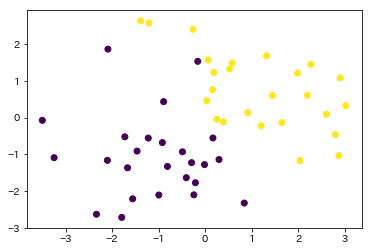

In [3]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)

## 最大事後確率推定（MAP推定）

### 学習

パラメータの推定量として、事後分布が最大となるパラメータを採用する手法である。

つまり、データを$X$、パラメータ$\boldsymbol{\theta}$に対する尤度関数を$p(X | \boldsymbol{\theta})$、$\boldsymbol{\theta}$の事前分布を$p(\boldsymbol{\theta})$とすると、

事後確率は$p(\boldsymbol{\theta} | X) = \frac{p(X | \boldsymbol{\theta}) p(\boldsymbol{\theta})}{p(X)}$であり、推定量は$\boldsymbol{\theta}_{MAP} = \text{argmax}_{\boldsymbol{\theta}} p(\boldsymbol{\theta} | X)$である。

訓練データを$X = [\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ..., \boldsymbol{x}_{n}]^{\mathrm{T}}, \boldsymbol{y} = [y_{1}, y_{2}, ..., y_{n}]^{\mathrm{T}} (y_{i} = \{0, 1\})$とする。

識別モデルとしてはロジスティック回帰モデル$p(y=1 | \boldsymbol{x}, \boldsymbol{w}) = \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})$を用いる。

ただし、$\sigma(\cdot)$はシグモイド関数であり、$\sigma(h) = \frac{1}{1 + \exp{(-h)}}$で定義される。また、

陽には書かないが、$\boldsymbol{x}$には定数項のための$1$という要素があることを仮定する。

パラメータ$\boldsymbol{w}$に対する尤度関数、$\boldsymbol{w}$の事前分布を以下のように仮定する。

$p(\boldsymbol{y} | X, \boldsymbol{w}) = \prod_{i=1}^{n} \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x})^{y_{i}} (1 - \sigma (\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}))^{1 - y_{i}}$

$p(\boldsymbol{w}; \alpha) = \mathcal{N} (\boldsymbol{w} | \boldsymbol{0}, \alpha^{-1}I)$

ただし、$\boldsymbol{w}=[w_{0}, w_{1}, ..., w_{d}]^{\mathrm{T}}$であり、$\alpha$はハイパーパラメータである。

事後分布は$p(\boldsymbol{w} | X, \boldsymbol{y}; \alpha) \propto p(\boldsymbol{y} | X, \boldsymbol{w}) p(\boldsymbol{w}; \alpha)$なので、

$\log{p(\boldsymbol{w} | X, \boldsymbol{y}; \alpha)} = \sum_{i=1}^{n} \left[ y_{i} \log{p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w})} + (1 - y_{i}) \log{(1 - p(y_{i}=1 | \boldsymbol{x}_{i}; \boldsymbol{w}))} \right] - \frac{\alpha}{2} \boldsymbol{w}^{\mathrm{T}} \boldsymbol{w} + const$

となり、$\boldsymbol{w}$に関して偏微分すると

$\frac{\partial}{\partial \boldsymbol{w}} \log{p(\boldsymbol{w} | X, \boldsymbol{y}; \alpha)} = \sum_{i=1}^{n} \left( y_{i} - \sigma(\boldsymbol{w}^{\mathrm{T}} \boldsymbol{x}_{i}) ) \right) \boldsymbol{x}_{i} - \alpha \boldsymbol{w}$

最急降下法（$\boldsymbol{w} \leftarrow \boldsymbol{w} + \eta \frac{\partial }{\partial \boldsymbol{w}} \log{L(\boldsymbol{w})}$）によってMAP推定量$\boldsymbol{w}_{MAP}$を求める。

In [4]:
def add_one(x):
    return np.concatenate([np.ones(len(x))[:, None], x], axis=1)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
X_train = add_one(x_train)
d = X_train.shape[1]

alpha = 0.01
max_iter=100
eta = 0.01
w = np.zeros(d)
for _ in range(max_iter):
    w_prev = np.copy(w)
    sigma = sigmoid(np.dot(X_train, w))
    grad = np.dot(X_train.T, (y_train - sigma)) - alpha * w
    w += eta * grad
    if np.allclose(w, w_prev):
        break
        
w_MAP = w

### 予測

入力に対して、$y=1$である確率は$p(y=1 | \boldsymbol{x}; \boldsymbol{w}_{MAP}) = \sigma (\boldsymbol{w}_{MAP}^{\mathrm{T}} \boldsymbol{x})$である。

In [6]:
xx0, xx1 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
xx = np.array([xx0, xx1]).reshape(2, -1).T

X_test = add_one(xx)
proba = sigmoid(np.dot(X_test, w_MAP))

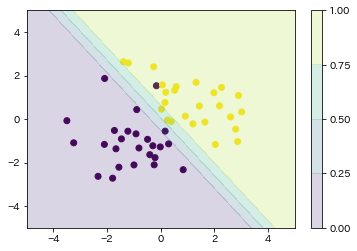

In [7]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(xx0, xx1, proba.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 5))
plt.colorbar()

## 予測分布

予測分布を求める際にパラメータ$\boldsymbol{w}$の事後分布に関して積分する必要があるが、上の場合解析的に得くことができない。

そこで事後分布をラプラス近似（近似する分布のモードとその周辺の共分散を用いてガウス分布で近似）する。計算の結果、事後分布の近似は以下のようになる。

$q(\boldsymbol{w}) = \mathcal{N} (\boldsymbol{w} | \boldsymbol{w}_{MAP}, S)$

$S = (\alpha I + X^{T} B X)^{-1}$

ただし、$B$は要素$b_{k} = \sigma (\boldsymbol{w}_{MAP}^{\mathrm{T}} \boldsymbol{x}_{k}) (1 - \sigma (\boldsymbol{w}_{MAP}^{\mathrm{T}} \boldsymbol{x}_{k}))$をもつ対角行列である。

さらにシグモイド関数もプロビット関数で近似することで、新しいデータ$\boldsymbol{x}$の予測分布を計算すると以下のようになる。

\begin{eqnarray}
p(y=1 | \boldsymbol{x}, X, \boldsymbol{y}; \alpha) &=& \int p(y=1 | \boldsymbol{x}, \boldsymbol{w}) p(\boldsymbol{w} | X, \boldsymbol{y}; \alpha) d \boldsymbol{w} \\
&\approx& \sigma(\kappa(\sigma_{a}) \mu_{a}) \\
\end{eqnarray}

ただし、
\begin{eqnarray}
\kappa(\sigma_{a}^{2}) &=& (1 + \pi \sigma_{a}^{2} / 8)^{-1/2} \\ 
\mu_{a} &=& \boldsymbol{w}_{MAP} \boldsymbol{x} \\
\sigma_{a}^{2} &=& \boldsymbol{x}^{\mathrm{T}} S \boldsymbol{x}
\end{eqnarray}

In [8]:
sigma = sigmoid(np.dot(X_train, w_MAP))
B = np.diag(sigma * (1 - sigma))
S = alpha * np.identity(d) + np.dot(X_train.T, B).dot(X_train)
var_a = np.sum(np.dot(X_test, S) * X_test, axis=1)
mu_a = np.dot(X_test, w_MAP)
kappa = 1. / np.sqrt(1 + np.pi * var_a / 8)
pred_proba = sigmoid(kappa * mu_a)

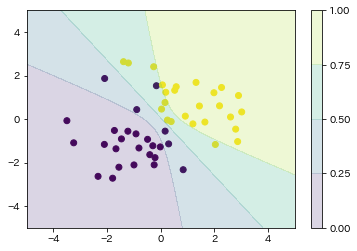

In [9]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(xx0, xx1, pred_proba.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 5))
plt.colorbar()